In [22]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, OPTICS
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
pca_2d_df = pd.read_json('pca_2d_df.json')
NUM_CLUSTERS = 4
pca_2d_df

,pca_weights
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC1-11.png,"[-0.170194447, 0.2974815369]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC1-16.png,"[-0.18904732170000002, 0.4561925828]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC1-18.png,"[-0.3008253574, -0.4050125778]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC1-6.png,"[-0.5911592841000001, -0.1082449481]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC10-10.png,"[-0.48596718910000003, -0.3093441725]"
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC95-5.png,"[-0.4500953555, -0.3747172058]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC97-12.png,"[-0.4562984705, -0.3416552544]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC97-15.png,"[-0.48083657030000004, -0.3439148962]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC99-2.png,"[-0.4736335278, -0.48556309940000003]"


### K-Means Clustering

In [24]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0, n_init="auto").fit(pca_2d_df['pca_weights'].to_list())
pca_2d_df['kmeans_cluster'] = kmeans.labels_

Text(0.5, 1.0, '2D representation of images clustered by KMeans')

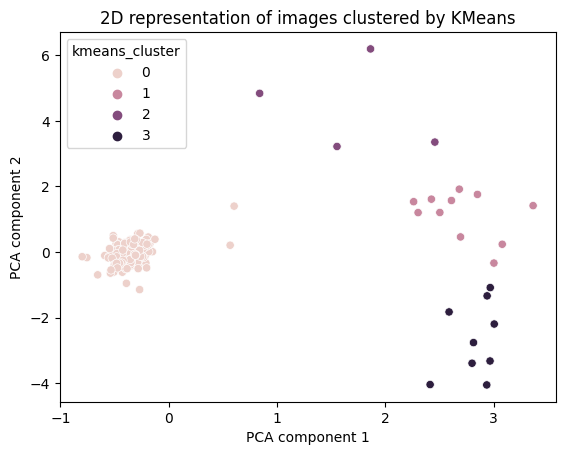

In [25]:
sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['kmeans_cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by KMeans')

### DBSCAN Clustering

In [26]:
%matplotlib inline

from matplotlib import interactive
from ipywidgets import interact

def g(eps=0.5):
    DBSCAN_clustering = DBSCAN(eps=eps, min_samples=2).fit(pca_2d_df['pca_weights'].to_list())
    pca_2d_df['DBSCAN_cluster'] = DBSCAN_clustering.labels_
    sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['DBSCAN_cluster'])
    plt.show()

interact(g, eps=(0.5, 3))

interactive(children=(FloatSlider(value=0.5, description='eps', max=3.0, min=0.5), Output()), _dom_classes=('w…

<function __main__.g(eps=0.5)>

In [27]:
# eps = max. dist ton still be considered neighbour
# min_samples = min. number of neighbours to be considered a core point
DBSCAN_clustering = DBSCAN(eps=0.5, min_samples=2).fit(pca_2d_df['pca_weights'].to_list())
pca_2d_df['DBSCAN_cluster'] = DBSCAN_clustering.labels_

Text(0.5, 1.0, '2D representation of images clustered by DBSCAN')

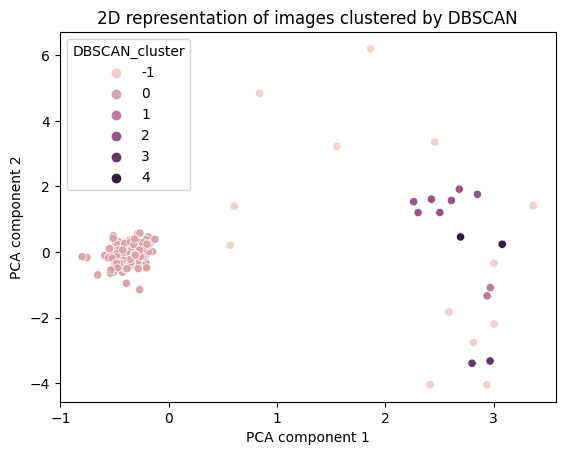

In [28]:
sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['DBSCAN_cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by DBSCAN')

### HDBSCAN*

In [29]:
%matplotlib inline

from matplotlib import interactive
from ipywidgets import interact

def h(minimum_cluster_size=5, min_samples=1):
    hdbscan_clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=minimum_cluster_size, min_samples=min_samples, p=None)
    hdbscan_clusterer.fit(pca_2d_df['pca_weights'].to_list())
    pca_2d_df['hdbscan_cluster'] = hdbscan_clusterer.labels_
    sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['hdbscan_cluster'])
    plt.show()

# minimum_cluster_size = min. number of points in a cluster
# min_samples = min. number of neighbours to be considered a core point
interact(h, minimum_cluster_size=(1, 7), min_samples=(1, 7))

interactive(children=(IntSlider(value=5, description='minimum_cluster_size', max=7, min=1), IntSlider(value=1,…

<function __main__.h(minimum_cluster_size=5, min_samples=1)>

In [30]:
hdbscan_clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)
hdbscan_clusterer.fit(pca_2d_df['pca_weights'].to_list())
pca_2d_df['hdbscan_cluster'] = hdbscan_clusterer.labels_

Text(0.5, 1.0, '2D representation of images clustered by HDBSCAN')

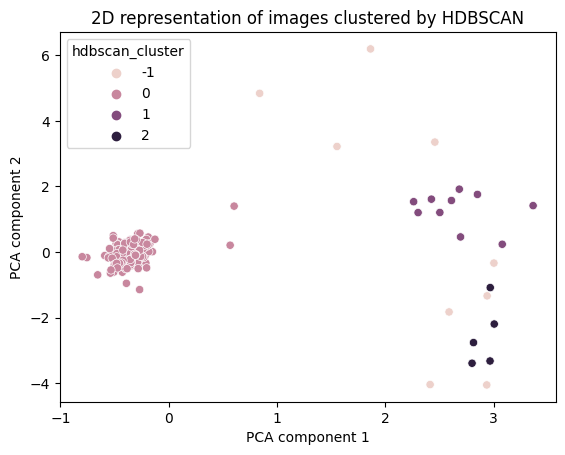

In [31]:
sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['hdbscan_cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by HDBSCAN')

### OPTICS

In [32]:
%matplotlib inline

from matplotlib import interactive
from ipywidgets import interact

def i(eps=1, min_samples=2, min_cluster_size=2):
    optics_clustering = OPTICS(min_samples=min_samples,eps=eps, min_cluster_size=min_cluster_size).fit(pca_2d_df['pca_weights'].to_list())
    pca_2d_df['optics_cluster'] = optics_clustering.labels_
    sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['hdbscan_cluster'])
    plt.show()

# eps = max. dist to still be considered neighbour
# min_samples = min. number of neighbours to be considered a core point
# min_cluster_size = min. number of points in a cluster
interact(i, eps=(1, 7), min_samples=(2, 7), min_cluster_size=(2, 7))

interactive(children=(IntSlider(value=1, description='eps', max=7, min=1), IntSlider(value=2, description='min…

<function __main__.i(eps=1, min_samples=2, min_cluster_size=2)>

In [33]:
optics_clustering = OPTICS(min_samples=2).fit(pca_2d_df['pca_weights'].to_list())
pca_2d_df['optics_cluster'] = optics_clustering.labels_

Text(0.5, 1.0, '2D representation of images clustered by OPTICS')

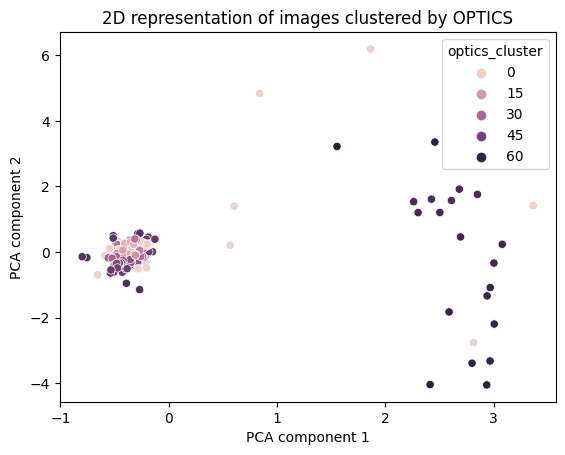

In [34]:
sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['optics_cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by OPTICS')

### Compare Clustering Algorithms

In [35]:
# save different clusterings to json
pca_2d_df.to_json('pca_2d_df_clusters.json')

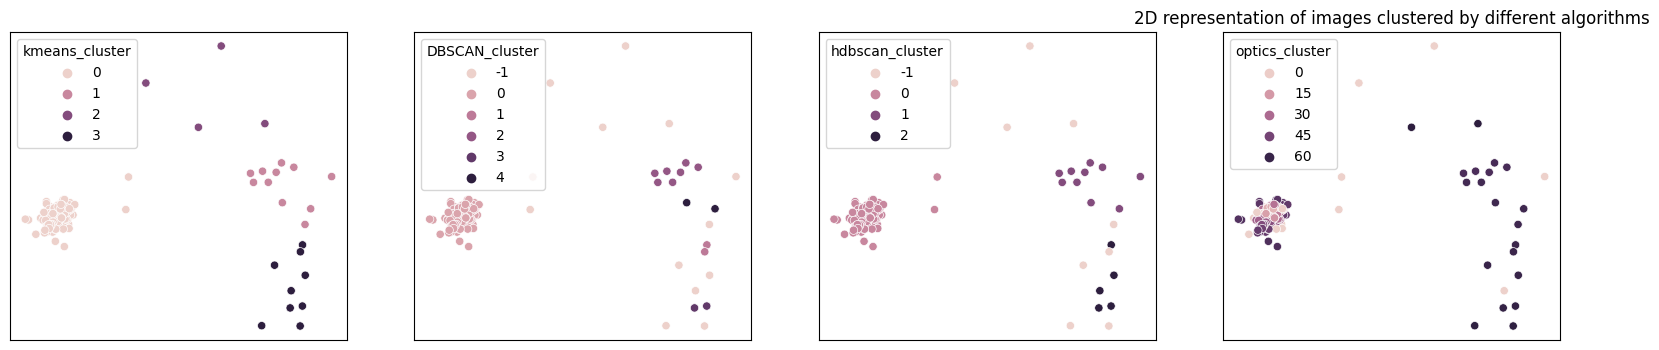

In [36]:
algos = list(pca_2d_df.keys())[1:]
num_algos = len(algos)
plt.figure(figsize=(20, 4))

for i in range(1, num_algos + 1):
    # Display original
    ax = plt.subplot(1, num_algos, i)
    sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df[algos[i - 1]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.title('2D representation of images clustered by different algorithms', loc='center')
plt.show()